In [2]:
import os
import pickle
import tempfile as tmp
import time
import warnings

# The following variables are not needed for every unix distribution, but are
# highlighted in here to prevent problems with multiprocessing with scikit-learn.
os.environ['JOBLIB_TEMP_FOLDER'] = tmp.gettempdir()
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn.datasets
import sklearn.model_selection
from sklearn.inspection import permutation_importance

from smac.tae import StatusType

from autoPyTorch.api.tabular_classification import TabularClassificationTask
from autoPyTorch.metrics import accuracy

# Data Loading

In [3]:
# We will use the iris dataset for this Toy example
seed = 42
X, y = sklearn.datasets.fetch_openml(data_id=61, return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    random_state=42,
)

# Build and fit a classifier

In [4]:
api = TabularClassificationTask(seed=seed)
api.search(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    optimize_metric=accuracy.name,
    total_walltime_limit=200,
    func_eval_time_limit_secs=50
)


[ERROR] [2023-04-06 06:59:46,805:Client-AutoPyTorch:9949b5d2-d448-11ed-82e1-0242ac1c000c:42] Prediction for lgb failed with run state StatusType.CRASHED.
Additional info:
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/autoPyTorch/evaluation/tae.py", line 61, in fit_predict_try_except_decorator
    ta(queue=queue, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/autoPyTorch/evaluation/train_evaluator.py", line 512, in eval_train_function
    evaluator.fit_predict_and_loss()
  File "/usr/local/lib/python3.9/dist-packages/autoPyTorch/evaluation/train_evaluator.py", line 186, in fit_predict_and_loss
    y_train_pred, y_opt_pred, y_valid_pred, y_test_pred = self._fit_and_predict(pipeline, split_id,
  File "/usr/local/lib/python3.9/dist-packages/autoPyTorch/evaluation/train_evaluator.py", line 364, in _fit_and_predict
    fit_and_suppress_warnings(self.logger, pipeline, X, y)
  File "/usr/local/lib/python3.9/dist-packages/autoPyTorch/eval

# Test Accuracy

In [5]:
# Calculate test accuracy
y_pred = api.predict(X_test)
score = api.score(y_pred, y_test)
print("Accuracy score", score)



Accuracy score {'accuracy': 1.0}


# Statistics

In [6]:

# Print statistics from search
print(api.sprint_statistics())

autoPyTorch results:
	Dataset name: 9949b5d2-d448-11ed-82e1-0242ac1c000c
	Optimisation Metric: accuracy
	Best validation score: 0.9459459459459459
	Number of target algorithm runs: 30
	Number of successful target algorithm runs: 13
	Number of crashed target algorithm runs: 16
	Number of target algorithms that exceeded the time limit: 1
	Number of target algorithms that exceeded the memory limit: 0



# Plotting the model performance

[WARNING] [2023-04-06 07:08:27,590:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[WARNING] [2023-04-06 07:08:27,625:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[WARNING] [2023-04-06 07:08:27,628:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[WARNING] [2023-04-06 07:08:27,633:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[WARNING] [2023-04-06 07:08:27,637:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[WARNING] [2023-04-06 07:08:27,639:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[WARNING] [2023-04-06 07:08:27,645:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[WARNING] [2023-04-06 07:08:27,689:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[WARNING] [2023-04-06 07:08:27,705:matplotlib.font_manager] findfont: Font family 'Times New Roman' not found.
[

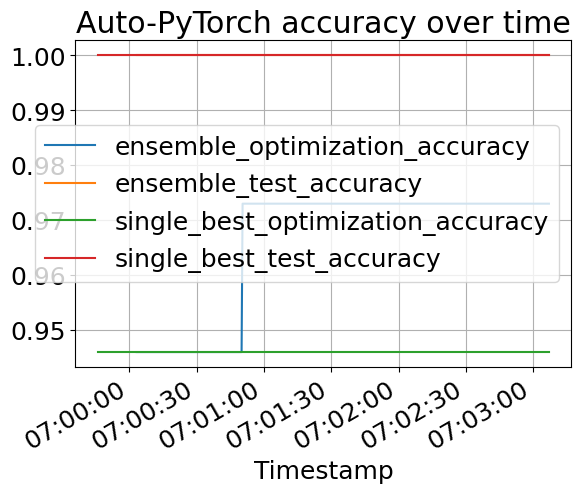

In [8]:
# We will plot the search incumbent through time.

# Collect the performance of individual machine learning algorithms
# found by SMAC
individual_performances = []
for run_key, run_value in estimator.run_history.data.items():
    if run_value.status != StatusType.SUCCESS:
        # Ignore crashed runs
        continue
    individual_performances.append({
        'Timestamp': pd.Timestamp(
            time.strftime(
                '%Y-%m-%d %H:%M:%S',
                time.localtime(run_value.endtime)
            )
        ),
        'single_best_optimization_accuracy': accuracy._optimum - run_value.cost,
        'single_best_test_accuracy': np.nan if run_value.additional_info is None else
        accuracy._optimum - run_value.additional_info['test_loss']['accuracy'],
    })
individual_performance_frame = pd.DataFrame(individual_performances)

# Collect the performance of the ensemble through time
# This ensemble is built from the machine learning algorithms
# found by SMAC
ensemble_performance_frame = pd.DataFrame(estimator.ensemble_performance_history)

# As we are tracking the incumbent, we are interested in the cummax() performance
ensemble_performance_frame['ensemble_optimization_accuracy'] = ensemble_performance_frame[
    'train_accuracy'
].cummax()
ensemble_performance_frame['ensemble_test_accuracy'] = ensemble_performance_frame[
    'test_accuracy'
].cummax()
ensemble_performance_frame.drop(columns=['test_accuracy', 'train_accuracy'], inplace=True)
individual_performance_frame['single_best_optimization_accuracy'] = individual_performance_frame[
    'single_best_optimization_accuracy'
].cummax()
individual_performance_frame['single_best_test_accuracy'] = individual_performance_frame[
    'single_best_test_accuracy'
].cummax()

pd.merge(
    ensemble_performance_frame,
    individual_performance_frame,
    on="Timestamp", how='outer'
).sort_values('Timestamp').fillna(method='ffill').plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-PyTorch accuracy over time',
    grid=True,
)
plt.show()